<a href="https://colab.research.google.com/github/afshars/text-classification/blob/main/text_classification_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stack Overflow Text Classification

**Author:** Sarah M Afshar  
**Email:** smartelectria@gmail.com  
**Date:** December 2025  


## Description

This notebook demonstrates building a text classification model using TensorFlow and Keras.

It presents a **baseline NLP approach for multi-class text classification** on Stack Overflow questions.


## Project Focus

The project focuses on:

- Text preprocessing
- Feature extraction
- Multi-class classification
- Model evaluation


**Note:** This notebook was created and compiled by Sarah M Afshar, using some external resources and references.


## Import Required Libraries

In this section, we import all the necessary libraries
used for data processing, model building, and evaluation.


In [ ]:
# Core libraries
import os
import re
import string
import shutil

# Numerical and visualization libraries
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

# Display TensorFlow version
print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.19.0


## Dataset : Stack Overflow Questions

In this section, we download and perform an initial exploration
of the Stack Overflow questions dataset used for multi-class
text classification.


In [ ]:
# Dataset URL
DATASET_URL = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

# Download and extract the dataset
dataset_path = tf.keras.utils.get_file(
    fname="stack_overflow_16k",
    origin=DATASET_URL,
    untar=True,
    cache_dir=".",
    cache_subdir=""
)

# Dataset directory
dataset_dir = dataset_path

print(f"Dataset directory: {dataset_dir}")


6053168/6053168 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Dataset directory: ./stack_overflow_16k


In [ ]:
# List the contents of the dataset directory
os.listdir(dataset_dir)

['README.md', 'test', 'train']

In [ ]:
# Path to training data directory
train_dir = os.path.join(dataset_dir, "train")

# List class subdirectories in training data
os.listdir(train_dir)


['javascript', 'java', 'python', 'csharp']

In [ ]:
# Read and display a sample training file
sample_file = os.path.join(train_dir, "python", "1026.txt")

with open(sample_file, encoding="utf-8") as f:
    sample_text = f.read()

print(sample_text[:500])  # Display only the first 500 characters


"how to normalize a 3d numpy array in blank? i want to normalize a 3d numpy array of shape 779, 6250, 19, where axis=0 is examples, axis=1 is data points and axis=2 is channels..its a time seried data. i am looking for a function like matlab normalize have. but in scikit library , only 2d array can be normalized. how can i normalize a 3d array in numpy"



## Load the Dataset

In this section, we load the text data from the directory structure
and prepare it for training and evaluation.


In [ ]:
# Dataset parameters
batch_size = 32
seed = 42

# Load training dataset
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed
)


Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [ ]:
# Display class names
raw_train_ds.class_names


['csharp', 'java', 'javascript', 'python']

In [ ]:
# Inspect a batch of text samples and labels
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(2):
        print(f"\nSample {i + 1}")
        print("Text:", text_batch.numpy()[i].decode("utf-8")[:300])
        print("Label:", label_batch.numpy()[i])



Sample 1
Text: "my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without pe
Label: 1

Sample 2
Text: "blank code slow skin detection this code changes the color space to lab and using a threshold finds the skin area of an image. but it's ridiculously slow. i don't know how to make it faster ?    ..from colormath.color_objects import *..def skindetection(img, treshold=80, color=[255,20,147]):..    p
Label: 3


In [ ]:
# Map label indices to class names
for i, class_name in enumerate(raw_train_ds.class_names):
    print(f"Label {i} --> {class_name}")


Label 0 --> csharp
Label 1 --> java
Label 2 --> javascript
Label 3 --> python


In [ ]:
# Create the validation dataset
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed
)


Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [ ]:
# Create the test dataset
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, "test"),
    batch_size=batch_size
)


Found 8000 files belonging to 4 classes.


## Prepare the Dataset for Training

In this section, we apply preprocessing steps to the datasets
to make them suitable for training the text classification model.

### Text Standardization

We define a custom text standardization function to clean the text
by converting it to lowercase and removing punctuation.


In [ ]:
def custom_standardization(input_text):
    """
    Standardizes text by converting to lowercase and
    removing punctuation characters.
    """
    lowercase = tf.strings.lower(input_text)
    return tf.strings.regex_replace(
        lowercase,
        f"[{re.escape(string.punctuation)}]",
        ""
    )


In [ ]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
# Maximum vocabulary size
max_features = 30000

# Maximum length of each sequence
sequence_length = 250

# Text vectorization layer
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length
)


### Adapt the Vectorization Layer

The vectorization layer is adapted on the training text
to learn the vocabulary from the dataset.


In [ ]:
# Extract text data (without labels) from the training dataset
train_text = raw_train_ds.map(lambda text, label: text)

# Adapt the vectorization layer to the training text
vectorize_layer.adapt(train_text)


In [ ]:
def vectorize_text(text, label):
    """
    Converts input text to a vector using the predefined vectorize_layer.

    Args:
        text: A string tensor containing the text.
        label: The corresponding label tensor.

    Returns:
        A tuple (vectorized_text, label)
    """
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


In [ ]:
# Retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))

# Pick the first review and label from the batch
first_review, first_label = text_batch[0], label_batch[0]

# Print the original text and its label
print("Review:", first_review)
print("Label:", raw_train_ds.class_names[first_label])

# Print the vectorized version of the first review
print("Vectorized review:", vectorize_text(first_review, first_label))


Review: tf.Tensor(b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n', shape=(), dtype=string)
Label: java
Vectorized review: (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 1011,   773,     9,  2456,     8,  1863,  2362,   690,  1267,
            4,    40,     5,     1,  1011,   196,    12,    74,    13,
           72,    33,     2,    98,   105,    14,     3,    70,  9611,
            3,    34,   888,   202,   773,   107,     8,    41, 

In [ ]:
# Print some example words from the vectorization vocabulary
print("Word at index 40 -->", vectorize_layer.get_vocabulary()[43])
print("Word at index 2410 -->", vectorize_layer.get_vocabulary()[908])

# Print the total vocabulary size
print('Vocabulary size:', len(vectorize_layer.get_vocabulary()))


Word at index 40 --> var
Word at index 2410 --> x1
Vocabulary size: 30000


In [ ]:
# Apply the vectorization function to all datasets
# This converts text data into integer sequences for the model

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)


### Configure the dataset for performance


In [ ]:
# Configure the datasets for performance
# AUTOTUNE lets TensorFlow choose the best buffer size for prefetching

AUTOTUNE = tf.data.AUTOTUNE

# Cache and prefetch datasets to improve performance
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


## Create the model

In this section, we define the neural network architecture for text classification.


In [ ]:
# Define the neural network architecture for text classification

embedding_dim = 16  # Dimension of the embedding vector

model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),  # Embedding layer for input words
    layers.Dropout(0.2),                           # Dropout for regularization
    layers.GlobalAveragePooling1D(),               # Reduce sequence dimension
    layers.Dropout(0.2),                           # Dropout again
    layers.Dense(4)                                 # Output layer (number of classes)
])

# Display the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Loss function and optimizer

In this section, we define the loss function and optimizer for training the text classification model.


In [ ]:
# Compile the model with loss function, optimizer, and evaluation metric

model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),  # Use sparse categorical crossentropy for integer labels
    optimizer= 'adam',                                              # Adam optimizer
    metrics=[tf.metrics.SparseCategoricalAccuracy()]               # Track accuracy during training
)


## Train the model

In this section, we train the text classification model using the prepared datasets.


In [ ]:
# Train the model for text classification

epochs = 15  # Number of training epochs

history = model.fit(
    train_ds,          # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=epochs      # Number of epochs
)


Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1.3804 - sparse_categorical_accuracy: 0.3149 - val_loss: 1.3584 - val_sparse_categorical_accuracy: 0.3706
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3422 - sparse_categorical_accuracy: 0.4166 - val_loss: 1.3072 - val_sparse_categorical_accuracy: 0.4325
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2815 - sparse_categorical_accuracy: 0.5044 - val_loss: 1.2259 - val_sparse_categorical_accuracy: 0.5225
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1926 - sparse_categorical_accuracy: 0.5934 - val_loss: 1.1333 - val_sparse_categorical_accuracy: 0.6306
Epoch 5/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0967 - sparse_categorical_accuracy: 0.6526 - val_loss: 1.0474 - val_sparse_categorical_accuracy: 0.6719
Epoch 6/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0097 - sparse_categorical_accuracy: 0.6822 - val_loss: 0.9717 - val_sparse_categorical_accuracy: 0.6956
Epo

## Evaluate the model

In this section, we evaluate the trained text classification model on the test dataset to measure its performance.


In [ ]:
# Evaluate the trained model on the test dataset
# Returns the loss value and accuracy

loss, accuracy = model.evaluate(test_ds)

print("Loss:", loss)
print("Accuracy:", accuracy)


250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.6953 - sparse_categorical_accuracy: 0.7425
Loss: 0.688724160194397
Accuracy: 0.7471250295639038


## Create a plot of accuracy and loss over time

In this section, we visualize the model's training and validation accuracy and loss over epochs.


In [ ]:
# Get the training history dictionary
# This contains loss and metric values for each epoch

history_dict = history.history
print(history_dict.keys())  # Print the keys to see available metrics


dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


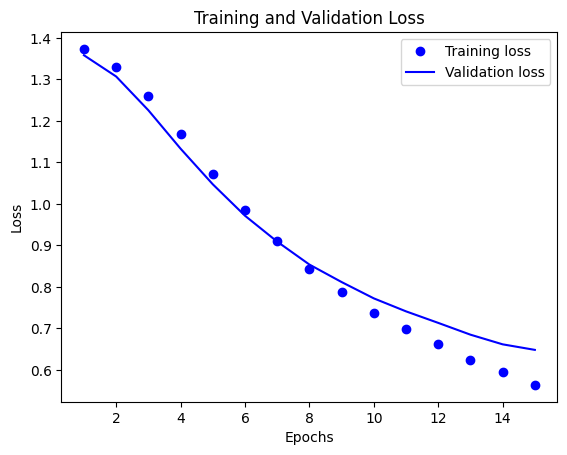

In [ ]:
# Retrieve loss and accuracy values from history
acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Plot training and validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')  # "bo" = blue dot
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # "b" = solid blue line
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


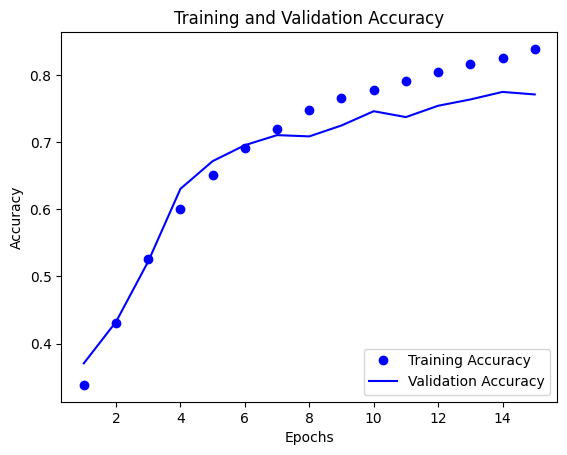

In [ ]:
# Plot training and validation accuracy over epochs
plt.plot(epochs, acc, 'bo', label='Training Accuracy')  # "bo" = blue dot
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')  # "b" = solid blue line
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


## Train 5 More Epochs with Lower Learning Rate

In this section, we continue training the model for 5 additional epochs using a lower learning rate to fine-tune its performance.


In [ ]:
# Re-compile the model with a lower learning rate to fine-tune
model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    metrics=[tf.metrics.SparseCategoricalAccuracy()]
)

# Continue training for 5 more epochs
epochs = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)



Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.5562 - sparse_categorical_accuracy: 0.8454 - val_loss: 0.6396 - val_sparse_categorical_accuracy: 0.7912
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5517 - sparse_categorical_accuracy: 0.8540 - val_loss: 0.6377 - val_sparse_categorical_accuracy: 0.7919
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5448 - sparse_categorical_accuracy: 0.8581 - val_loss: 0.6364 - val_sparse_categorical_accuracy: 0.7919
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5402 - sparse_categorical_accuracy: 0.8519 - val_loss: 0.6338 - val_sparse_categorical_accuracy: 0.7919
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5385 - sparse_categorical_accuracy: 0.8592 - val_loss: 0.6316 - val_sparse_categorical_accuracy: 0.7931


In [ ]:
# Evaluate the fine-tuned model on the test dataset
# Returns the final loss and accuracy

loss, accuracy = model.evaluate(test_ds)

print("Loss:", loss)
print("Accuracy:", accuracy)


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6820 - sparse_categorical_accuracy: 0.7579
Loss: 0.67353755235672
Accuracy: 0.7662500143051147


## Export the Model

In this section, we save the trained model so that it can be reused or deployed without retraining.


In [ ]:
# Create an exportable model that includes the text vectorization layer
# and applies a softmax activation at the end
export_model = tf.keras.Sequential([
    vectorize_layer,          # Convert raw text to integer sequences
    model,                    # The trained model
    layers.Activation('softmax')  # Convert logits to probabilities
])

# Compile the export model with proper loss and metrics
export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=['accuracy']
)

# Evaluate the export_model on raw test data (strings)
loss, accuracy = export_model.evaluate(raw_test_ds)
print("Test Accuracy:", accuracy)


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7588 - loss: 0.6811
Test Accuracy: 0.7662500143051147


## Inference on New Data

In this section, we use the exported model to predict the class of new, unseen text inputs.


In [ ]:
# Create some new example sentences for inference
examples = tf.constant([
    "Sentence 1: {public static void main(String[] args)}",
    "Sentence 2: def greet():",
    "Sentence 3: using System;"
])

# Use the exported model to predict class probabilities
predictions = export_model.predict(examples)

# Display predictions (probabilities for each class)
predictions


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


array([[0.35471842, 0.509058  , 0.07464055, 0.06158309],
       [0.2064459 , 0.20228423, 0.25371468, 0.33755517],
       [0.29069293, 0.23510799, 0.2646016 , 0.20959748]], dtype=float32)

In [ ]:
# Define class names corresponding to the output labels
class_names = ['csharp', 'java', 'javascript', 'python']

# Get the predicted class indices
labels = np.argmax(predictions, axis=1)

# Print the predicted class and its probability for each sentence
for i, label_id in enumerate(labels):
    print(f"Sentence {i+1}: {class_names[label_id]}  (prob={predictions[i][label_id]:.3f})")


Sentence 1: java  (prob=0.509)
Sentence 2: python  (prob=0.338)
Sentence 3: csharp  (prob=0.291)


## Visualize the Embedding Layer

In this section, we explore and visualize the word embeddings learned by the model to understand how it represents different words.


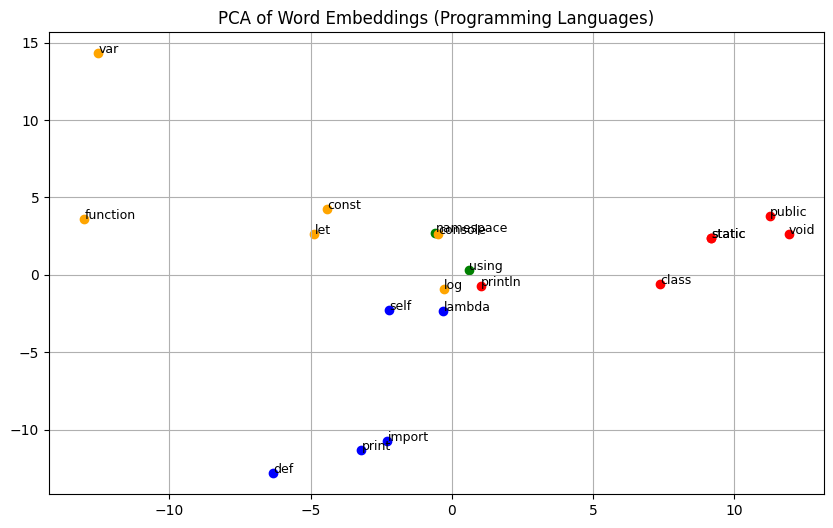

In [ ]:
# Extract embedding weights from the embedding layer
embedding_weights = model.layers[0].get_weights()[0]  # shape: (vocab_size, embedding_dim)

# Get the vocabulary and word indices
vocab = vectorize_layer.get_vocabulary()
word_index = {word: idx for idx, word in enumerate(vocab)}

# Select some representative words from each programming language
java_words = ['class', 'public', 'static', 'void', 'System', 'println']
python_words = ['def', 'print', 'lambda', 'import', 'self', 'None']
csharp_words = ['Console', 'WriteLine', 'using', 'namespace', 'static', 'Main']
javascript_words = ['function', 'console', 'log', 'var', 'let', 'const']

all_words = java_words + python_words + csharp_words + javascript_words

# Filter only words that exist in the vocabulary
selected_words = [w for w in all_words if w in word_index]
selected_indices = [word_index[word] for word in selected_words]
selected_embeddings = embedding_weights[selected_indices]

# Reduce embedding dimensions to 2D using PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(selected_embeddings)

# Assign colors for each language
colors = []
for w in selected_words:
    if w in java_words:
        colors.append('red')
    elif w in python_words:
        colors.append('blue')
    elif w in csharp_words:
        colors.append('green')
    else:  # javascript_words
        colors.append('orange')

# Plot the PCA-reduced embeddings
plt.figure(figsize=(10, 6))
for i, word in enumerate(selected_words):
    x, y = reduced[i]
    plt.scatter(x, y, c=colors[i])
    plt.text(x + 0.01, y + 0.01, word, fontsize=9)

plt.title("PCA of Word Embeddings (Programming Languages)")
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


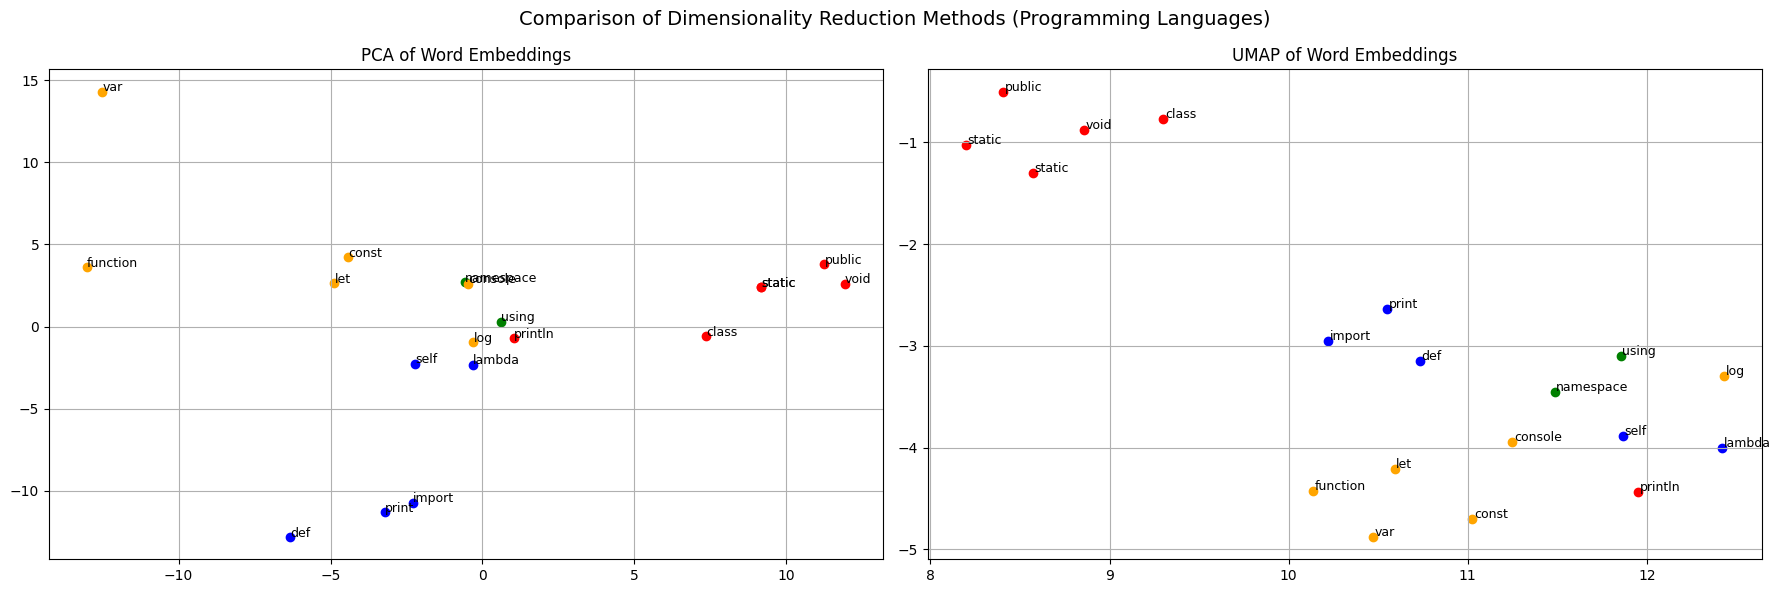

In [ ]:
# Reduce embedding dimensions using PCA
reduced_pca = PCA(n_components=2).fit_transform(selected_embeddings)

# Reduce embedding dimensions using UMAP
reduced_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(selected_embeddings)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
methods = ['PCA', 'UMAP']
reductions = [reduced_pca, reduced_umap]

# Assign colors for each programming language
word_colors = []
for w in selected_words:
    if w in java_words:
        word_colors.append('red')
    elif w in python_words:
        word_colors.append('blue')
    elif w in csharp_words:
        word_colors.append('green')
    else:  # javascript_words
        word_colors.append('orange')

# Plot each method
for ax, method, reduced in zip(axes, methods, reductions):
    for i, word in enumerate(selected_words):
        x, y = reduced[i]
        ax.scatter(x, y, c=word_colors[i])
        ax.text(x + 0.01, y + 0.01, word, fontsize=9)
    ax.set_title(f"{method} of Word Embeddings")
    ax.grid(True)

plt.suptitle("Comparison of Dimensionality Reduction Methods (Programming Languages)", fontsize=14)
plt.tight_layout()
plt.show()


# Summary

In this notebook, we have:
- Loaded and preprocessed Stack Overflow dataset.
- Vectorized text and optimized datasets for performance.
- Built, trained, and fine-tuned a text classification model.
- Evaluated the model on a test set.
- Exported the model for inference on new data.
- Visualized the learned word embeddings using PCA and UMAP.

You can now use `export_model` for predicting new text inputs or further fine-tuning.
